In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
n = ['id', 'date', 'name', 'text', 'type', 'rep', 'rtw', 'fav', 'stcount', 'foll', 'friends', 'listcount']

positive = pd.read_csv("/content/drive/My Drive/datasets/positive.csv", sep=';', comment='#', header = None, names = n)
negative = pd.read_csv("/content/drive/My Drive/datasets/negative.csv", sep=';', comment='#', header = None, names = n)

In [ ]:
import numpy as np

sample_size = min(positive.shape[0], negative.shape[0])
raw_data = np.concatenate((positive['text'].values[:sample_size],
                           negative['text'].values[:sample_size]), axis=0)
labels = [1] * sample_size + [0] * sample_size

In [ ]:
raw_data[:5]

array(['@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)',
       'Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D',
       'RT @KatiaCheh: Ну ты идиотка) я испугалась за тебя!!!',
       'RT @digger2912: "Кто то в углу сидит и погибает от голода, а мы ещё 2 порции взяли, хотя уже и так жрать не хотим" :DD http://t.co/GqG6iuE2…',
       '@irina_dyshkant Вот что значит страшилка :D\nНо блин,посмотрев все части,у тебя создастся ощущение,что авторы курили что-то :D'],
      dtype=object)

In [ ]:
import re

def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) 
    text = re.sub('[a-zA-z]+', ' ', text)
    text = re.sub('@[^\s]+', ' ', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    
    return text.strip()

data = [preprocess_text(t) for t in raw_data]

In [ ]:
data[:10]

['хоть я и школота но поверь у нас то же самое общество профилирующий предмет типа',
 'да все таки он немного похож на него но мой мальчик все равно лучше',
 'ну ты идиотка я испугалась за тебя',
 '2912 кто то в углу сидит и погибает от голода а мы еще 2 порции взяли хотя уже и так жрать не хотим',
 'вот что значит страшилка но блин посмотрев все части у тебя создастся ощущение что авторы курили что то',
 'ну любишь или нет я не знаю кто ты бля',
 'ох 9 ну это конечно же чтобы у нее было много друзей ведь она такая мимими 3',
 'у тебя есть ухажер нет мои уши не кто не жрет',
 'поприветствуем моего нового читателя 1789',
 'теперь у меня есть частичка сиднея']

In [ ]:
!pip install pymorphy2


     |████████████████████████████████| 61kB 672kB/s 
     |████████████████████████████████| 8.2MB 5.5MB/s 


In [ ]:
import pymorphy2
import nltk
nltk.download("stopwords")
nltk.download("punkt")
 

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

# Создаем леммантизатор и список стоп-слов
morph = pymorphy2.MorphAnalyzer()
russian_stopwords = stopwords.words("russian")
stop_words = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def nltk_preprocess_text(text):
    tokens = word_tokenize(text, language="russian")
    filtered_tokens = []
    for token in tokens:
      if token not in stop_words:
          token = morph.parse(token)[0].normal_form
          filtered_tokens.append(token)
    text = " ".join(filtered_tokens)
    return text
data_prep = [nltk_preprocess_text(t) for t in data]

In [ ]:
data_prep[:3]

['школотый поверь самый общество профилировать предмет тип',
 'таки немного похожий мальчик равно',
 'идиотка испугаться']

In [ ]:
d = {'data_cleaned':data_prep, 'mark':labels}
df = pd.DataFrame(d)
df

,data_cleaned,mark
0,школотый поверь самый общество профилировать п...,1
1,таки немного похожий мальчик равно,1
2,идиотка испугаться,1
3,2912 угол сидеть погибать голод 2 порция взять...,1
4,значит страшилка блин посмотреть часть создать...,1
...,...,...
223841,каждый хотеть исправлять,0
223842,скучать вправлять мозг равно скучать,0
223843,школа говно это идти,0
223844,тауриэль грусть обнять,0


In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(df['data_cleaned'], df['mark'], shuffle = True, test_size=0.2)

max_len = 50
print(f'Примем за максимальное количество слов в предложении: {max_len}')

Примем за максимальное количество слов в предложении: 50


In [ ]:
ytrain[:5]

134409    0
23301     1
154753    0
96759     1
92155     1
Name: mark, dtype: int64

In [ ]:
max_words = 10000
tokenizer = text.Tokenizer(num_words = max_words)

tokenizer.fit_on_texts(xtrain)

xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xtest_seq = tokenizer.texts_to_sequences(xtest)

xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)
word_index = tokenizer.word_index


In [ ]:
xtrain

134409    быть завтра фотаться собака лиза милый 3 это ф...
23301     вежливый отправлять дальний нахуй жалко размен...
154753    беспорядок сам запутаться сигать бердыев мрн м...
96759                     думать дом один сестра проснуться
92155     залипать комп слушать репчин мочь настроиться ...
                                ...                        
64977     знать какой регин нижний бельё савик твой фонт...
67065           предстоящий чт конкурс думать пятница нарма
215888                                     классный гыгыгга
16520                                       подруга даааааа
54243                72 47 это одобрять львить столица киев
Name: data_cleaned, Length: 179076, dtype: object

In [ ]:
print('пример:', xtrain[2:3])
print('до padding:', xtrain_seq[2])
print('после padding:', xtrain_pad[2])

пример: 154753    беспорядок сам запутаться сигать бердыев мрн м...
Name: data_cleaned, dtype: object
до padding: [8506, 53, 2442, 321, 722]
после padding: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 8506   53 2442  321  722]


In [ ]:
%tensorflow_version 2.x
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN 
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 



---



---



Word2vec

In [ ]:
import gensim
import multiprocessing
from gensim.models import Word2Vec
def read_questions(row):
    return gensim.utils.simple_preprocess(str(row).encode('utf-8'))
    
sentences = []
for row in df['data_cleaned']:
    sentences.append(read_questions(row))

In [ ]:
sentences[0:3]

[['школотый',
  'поверь',
  'самый',
  'общество',
  'профилировать',
  'предмет',
  'тип'],
 ['таки', 'немного', 'похожий', 'мальчик', 'равно'],
 ['идиотка', 'испугаться']]

In [ ]:
num_words = 100000
sentence_length = max_len
# вычислили в процессе построения словаря
embedding_size = 200

In [ ]:
model_w2v = gensim.models.Word2Vec(size=200, window=5, min_count=3, workers=multiprocessing.cpu_count())
model_w2v.build_vocab(sentences)  

In [ ]:
model_w2v.train(sentences = sentences, total_examples = len(sentences), epochs = model_w2v.iter)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.


(6493004, 7205555)

In [ ]:
data_example = model_w2v.most_similar('думать')
print(data_example)

[('наверное', 0.7998193502426147), ('наверно', 0.7658997178077698), ('точно', 0.7648589611053467), ('неужели', 0.7594778537750244), ('уверенный', 0.7525678277015686), ('жалеть', 0.7464075088500977), ('значит', 0.7458125352859497), ('привыкнуть', 0.745547890663147), ('объяснять', 0.7423334717750549), ('замус', 0.7417981028556824)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
word_vectors = model_w2v.wv

In [ ]:
word_vectors.index2entity[:10]

['это',
 'хотеть',
 'день',
 'такой',
 'сегодня',
 'быть',
 'очень',
 'мой',
 'ты',
 'знать']

In [ ]:
embedding_vector = word_vectors['это']
embedding_vector.shape

(200,)

In [ ]:
EMBEDDING_DIM = 200
vocabulary_size = min(len(word_index)+1, max_words)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>= max_words:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)


In [ ]:
embedding_matrix[1]

array([ 0.55544156, -0.39380041, -0.22345535, -0.03918546,  0.33611917,
        0.21653375, -0.47190988, -0.6217795 ,  0.80244446,  0.25249422,
       -0.51968503, -0.3860929 , -0.09647284,  0.48078609, -0.19762461,
        0.39689201,  0.14878556, -0.48805323, -0.60942656, -0.23960902,
        0.95447612, -0.00205228, -0.09878159, -0.25783062, -1.10582829,
        0.6666171 ,  0.01853548,  0.37641355, -0.29472825, -0.17733532,
        0.78544098, -0.66896975, -0.22325908,  0.56116772,  0.30184501,
        0.25106531, -0.26743099,  0.05685185, -0.40118721, -0.56478292,
        0.17258646,  0.09616009,  0.9228763 ,  0.32457095,  0.25763753,
        1.10589862,  0.44248024,  0.38967574,  0.64464974, -0.21679831,
       -0.32062677, -0.2527746 , -0.28507143,  0.7652086 , -0.2617918 ,
        0.243111  , -1.08597982,  0.32278717,  0.72478896,  0.12793675,
       -0.6146161 , -0.52112943, -0.44354755,  0.20874168,  0.12831348,
        0.48528841,  0.35580605,  0.74416703, -0.12347947,  0.36

In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers


In [ ]:
###  С ИСПОЛЬЗОВАНИЕМ ЭМБЕДДИНГ МАТРИЦЫ
lstm_model = Sequential()
lstm_model.add(Embedding(vocabulary_size, 200, trainable = False, weights=[embedding_matrix]))
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation = 'sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,168,577
Trainable params: 168,577
Non-trainable params: 2,000,000
_________________________________________________________________
None


In [ ]:
%%time
batch_size = 256
epochs  = 10
history = lstm_model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)

Epoch 1/10
700/700 [==============================] - 7s 11ms/step - loss: 0.6393 - accuracy: 0.6248 - val_loss: 0.6188 - val_accuracy: 0.6479
Epoch 2/10
700/700 [==============================] - 7s 10ms/step - loss: 0.6124 - accuracy: 0.6559 - val_loss: 0.6035 - val_accuracy: 0.6629
Epoch 3/10
700/700 [==============================] - 7s 10ms/step - loss: 0.6004 - accuracy: 0.6665 - val_loss: 0.5959 - val_accuracy: 0.6701
Epoch 4/10
700/700 [==============================] - 7s 11ms/step - loss: 0.5910 - accuracy: 0.6756 - val_loss: 0.5975 - val_accuracy: 0.6668
Epoch 5/10
700/700 [==============================] - 7s 10ms/step - loss: 0.5837 - accuracy: 0.6826 - val_loss: 0.5877 - val_accuracy: 0.6788
Epoch 6/10
700/700 [==============================] - 7s 10ms/step - loss: 0.5771 - accuracy: 0.6875 - val_loss: 0.5848 - val_accuracy: 0.6820
Epoch 7/10
700/700 [==============================] - 7s 10ms/step - loss: 0.5701 - accuracy: 0.6932 - val_loss: 0.5824 - val_accuracy: 0.6848

Text(0.5, 1.0, 'Accuracy')

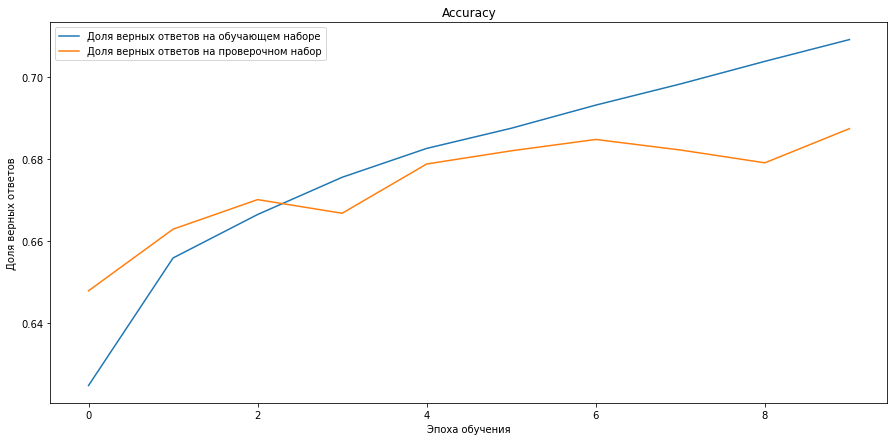

In [ ]:
epochs = 10
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['Доля верных ответов на обучающем наборе', 'Доля верных ответов на проверочном набор'])
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Accuracy')

In [ ]:
scores_1 = lstm_model.evaluate(xtest_pad, ytest, verbose=1)

1400/1400 [==============================] - 4s 3ms/step - loss: 0.5813 - accuracy: 0.6874


In [ ]:
text1 = ['отличный день']
text2 = ['меня бесит, что у меня ничего не получается']
text1_seq = tokenizer.texts_to_sequences(text1)
text2_seq = tokenizer.texts_to_sequences(text2)
text1_pad = sequence.pad_sequences(text1_seq, maxlen=max_len)
text2_pad = sequence.pad_sequences(text2_seq, maxlen=max_len)

result_lstm1 = lstm_model.predict(text1_pad)
result_lstm2 = lstm_model.predict(text2_pad)

print(result_lstm1)
print(result_lstm2)

for result in [result_lstm1, result_lstm2]: 
  if result < 0.5:
      print('Отзыв отрицательный')
  else:
      print('Отзыв положительный')


[[0.92735076]]
[[0.36496496]]
Отзыв положительный
Отзыв отрицательный


In [ ]:
# более сложные отзывы
text3 = ['курсовая работа была сложной, но я полностью разобралась']
text4 = ['курсовая работа была очень сложной, и я не разобралась']
text3_seq = tokenizer.texts_to_sequences(text3)
text3_pad = sequence.pad_sequences(text3_seq, maxlen=max_len)
text4_seq = tokenizer.texts_to_sequences(text4)
text4_pad = sequence.pad_sequences(text4_seq, maxlen=max_len)

result_3 = lstm_model.predict(text3_pad)
result_4 = lstm_model.predict(text4_pad)
print(result_3)
print(result_4)
for result in [result_3, result_4]:
  if result < 0.5:
        print('Отзыв отрицательный') 
  else:
        print('Отзыв положительный')

[[0.47257808]]
[[0.3528063]]
Отзыв отрицательный
Отзыв отрицательный


In [ ]:
lstm_pred = lstm_model.predict(xtest_pad)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, lstm_pred.round()))

FP = confusion_matrix(ytest, lstm_pred.round())[0][1]
FN = confusion_matrix(ytest, lstm_pred.round())[1][0]

print('False Positive (ошибка 1го рода): ', FP)
print('False Negative (ошибка 2го рода): ', FN)
print('len array', len(lstm_pred))

accuracy = 100-((FP+FN)*100/len(lstm_pred))
print(accuracy)

[[14959  7345]
 [ 6648 15818]]
False Positive (ошибка 1го рода):  7345
False Negative (ошибка 2го рода):  6648
len array 44770
68.74469510833147


In [ ]:
### ДАННЫЕ БЕЗ ЛЕММАТИЗАЦИИ
xtrain1, xtest1, ytrain1, ytest1 = train_test_split(data, df['mark'], shuffle = True, test_size=0.2)
tokenizer = text.Tokenizer(num_words = max_words)

tokenizer.fit_on_texts(xtrain1)

xtrain_seq1 = tokenizer.texts_to_sequences(xtrain1)
xtest_seq1 = tokenizer.texts_to_sequences(xtest1)

xtrain_pad1 = sequence.pad_sequences(xtrain_seq1, maxlen=max_len)
xtest_pad1 = sequence.pad_sequences(xtest_seq1, maxlen=max_len)
word_index1 = tokenizer.word_index

In [ ]:
lstm_model_1 = Sequential()
lstm_model_1.add(Embedding(vocabulary_size, 200, trainable = False, weights=[embedding_matrix]))
lstm_model_1.add(LSTM(128, return_sequences=False))
lstm_model_1.add(Dropout(0.5))
lstm_model_1.add(Dense(1, activation = 'sigmoid'))
lstm_model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
%%time
batch_size = 256
epochs  = 10
history1 = lstm_model_1.fit(xtrain_pad1, np.asarray(ytrain1), validation_data=(xtest_pad1, np.asarray(ytest1)), batch_size = batch_size, epochs = epochs)

Epoch 1/10
700/700 [==============================] - 8s 12ms/step - loss: 0.6512 - accuracy: 0.6156 - val_loss: 0.6294 - val_accuracy: 0.6421
Epoch 2/10
700/700 [==============================] - 8s 11ms/step - loss: 0.6221 - accuracy: 0.6493 - val_loss: 0.6128 - val_accuracy: 0.6564
Epoch 3/10
700/700 [==============================] - 8s 11ms/step - loss: 0.6056 - accuracy: 0.6662 - val_loss: 0.6007 - val_accuracy: 0.6679
Epoch 4/10
700/700 [==============================] - 8s 11ms/step - loss: 0.5922 - accuracy: 0.6792 - val_loss: 0.5940 - val_accuracy: 0.6753
Epoch 5/10
700/700 [==============================] - 8s 11ms/step - loss: 0.5801 - accuracy: 0.6889 - val_loss: 0.5932 - val_accuracy: 0.6757
Epoch 6/10
700/700 [==============================] - 8s 11ms/step - loss: 0.5700 - accuracy: 0.6965 - val_loss: 0.5835 - val_accuracy: 0.6835
Epoch 7/10
700/700 [==============================] - 8s 11ms/step - loss: 0.5603 - accuracy: 0.7052 - val_loss: 0.5832 - val_accuracy: 0.6834

In [ ]:
scores_1_1 = lstm_model_1.evaluate(xtest_pad1, ytest1, verbose=1)

1400/1400 [==============================] - 5s 3ms/step - loss: 0.5798 - accuracy: 0.6918


In [ ]:
### МОДЕЛЬ БЕЗ ИСПОЛЬЗОВАНИЯ МАТРИЦЫ ВЕСОВ
lstm_model_no = Sequential()
lstm_model_no.add(Embedding(vocabulary_size, 200))
lstm_model_no.add(LSTM(128, return_sequences=False))
lstm_model_no.add(Dropout(0.5))
lstm_model_no.add(Dense(1, activation = 'sigmoid'))
lstm_model_no.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
%%time
batch_size = 256
epochs  = 10
history_no = lstm_model_no.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)

Epoch 1/10
700/700 [==============================] - 26s 37ms/step - loss: 0.5724 - accuracy: 0.6960 - val_loss: 0.5475 - val_accuracy: 0.7196
Epoch 2/10
700/700 [==============================] - 25s 36ms/step - loss: 0.5179 - accuracy: 0.7395 - val_loss: 0.5447 - val_accuracy: 0.7196
Epoch 3/10
700/700 [==============================] - 25s 36ms/step - loss: 0.4865 - accuracy: 0.7577 - val_loss: 0.5592 - val_accuracy: 0.7192
Epoch 4/10
700/700 [==============================] - 25s 35ms/step - loss: 0.4575 - accuracy: 0.7729 - val_loss: 0.5789 - val_accuracy: 0.7152
Epoch 5/10
700/700 [==============================] - 24s 35ms/step - loss: 0.4274 - accuracy: 0.7890 - val_loss: 0.6152 - val_accuracy: 0.7124
Epoch 6/10
700/700 [==============================] - 24s 35ms/step - loss: 0.3965 - accuracy: 0.8055 - val_loss: 0.6555 - val_accuracy: 0.7098
Epoch 7/10
700/700 [==============================] - 24s 34ms/step - loss: 0.3657 - accuracy: 0.8211 - val_loss: 0.6910 - val_accuracy:

In [ ]:
scores_1_no = lstm_model_no.evaluate(xtest_pad, ytest, verbose=1)

1400/1400 [==============================] - 5s 4ms/step - loss: 1.0309 - accuracy: 0.7001


cnn


In [ ]:
model_cnn = Sequential()
model_cnn.add(Embedding(max_words, 200, input_length = max_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(1, activation='sigmoid'))

In [ ]:
model_cnn.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 200)           2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 250)           250250    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32128     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 2,282,507
Trainable params: 2,282,507
Non-trainable params: 0
____________________________________________

In [ ]:
%%time
callbacks = [EarlyStopping(monitor='val_loss')]

history_cnn = model_cnn.fit(xtrain_pad, 
                    ytrain, 
                    epochs=10,
                    batch_size=256, validation_split = 0.1,  callbacks = [callbacks])

Epoch 1/10
630/630 [==============================] - 17s 28ms/step - loss: 0.0464 - accuracy: 0.9795 - val_loss: 2.4468 - val_accuracy: 0.6906
Epoch 2/10
630/630 [==============================] - 17s 28ms/step - loss: 0.0430 - accuracy: 0.9812 - val_loss: 2.4295 - val_accuracy: 0.6894
Epoch 3/10
630/630 [==============================] - 17s 28ms/step - loss: 0.0413 - accuracy: 0.9816 - val_loss: 2.5068 - val_accuracy: 0.6933
CPU times: user 1min 8s, sys: 3.41 s, total: 1min 12s
Wall time: 52.4 s


Text(0.5, 1.0, 'Accuracy')

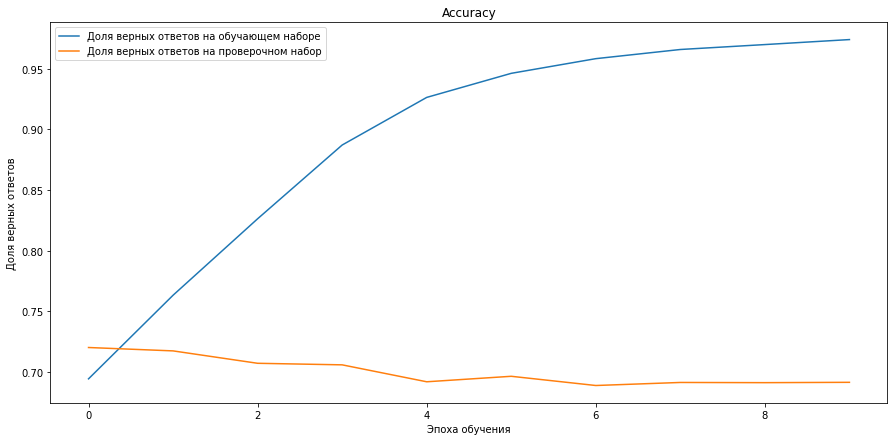

In [ ]:
epochs = 10
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history_cnn.history['accuracy'])
plt.plot(range(epochs), history_cnn.history['val_accuracy'])
plt.legend(['Доля верных ответов на обучающем наборе', 'Доля верных ответов на проверочном набор'])
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Accuracy')

In [ ]:
model_cnn.evaluate(xtest_pad, ytest, verbose=1)

1400/1400 [==============================] - 3s 2ms/step - loss: 2.4653 - accuracy: 0.6937


[2.4652838706970215, 0.6936787962913513]

In [ ]:
text_1 = ['отличный день']
text_2 = ['меня бесит, что у меня ничего не получается']
text1_seq = tokenizer.texts_to_sequences(text_1)
text2_seq = tokenizer.texts_to_sequences(text_2)
text1_pad = sequence.pad_sequences(text1_seq, maxlen=max_len)
text2_pad = sequence.pad_sequences(text2_seq, maxlen=max_len)

result_cnn1 = model_cnn.predict(text1_pad)
result_cnn2 = model_cnn.predict(text2_pad)

print(result_cnn1)
print(result_cnn2)

[[0.02478812]]
[[0.04972959]]


In [ ]:
for result in [result_cnn1, result_cnn2]: 
  if result < 0.5:
      print('Отзыв отрицательный')
  else:
      print('Отзыв положительный')

Отзыв отрицательный
Отзыв отрицательный


In [ ]:
# более сложные отзывы
text3 = ['курсовая работа была сложной, но я полностью разобралась']
text4 = ['курсовая работа была очень сложной, и я не разобралась']
text3_seq = tokenizer.texts_to_sequences(text3)
text3_pad = sequence.pad_sequences(text3_seq, maxlen=max_len)
text4_seq = tokenizer.texts_to_sequences(text4)
text4_pad = sequence.pad_sequences(text4_seq, maxlen=max_len)

result_3 = model_cnn.predict(text3_pad)
result_4 = model_cnn.predict(text4_pad)
print(result_3)
print(result_4)
for result in [result_3, result_4]:
  if result < 0.5:
        print('Отзыв отрицательный') 
  else:
        print('Отзыв положительный')

[[4.7128815e-06]]
[[1.9489962e-05]]
Отзыв отрицательный
Отзыв отрицательный




---




---



---



In [ ]:
model_cnn_1 = Sequential()
model_cnn_1.add(Embedding(max_words, 200, input_length = max_len, trainable = False, weights=[embedding_matrix]))
model_cnn_1.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn_1.add(GlobalMaxPooling1D())
model_cnn_1.add(Dense(128, activation='relu'))
model_cnn_1.add(Dropout(0.2))
model_cnn_1.add(Dense(1, activation='sigmoid'))

In [ ]:
model_cnn_1.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
%%time
callbacks = [EarlyStopping(monitor='val_loss')]
batch_size = 256
epochs  = 10
history = model_cnn_1.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs, callbacks=[callbacks])

Epoch 1/10
700/700 [==============================] - 6s 9ms/step - loss: 0.6409 - accuracy: 0.6242 - val_loss: 0.6185 - val_accuracy: 0.6454
Epoch 2/10
700/700 [==============================] - 6s 8ms/step - loss: 0.6110 - accuracy: 0.6565 - val_loss: 0.6101 - val_accuracy: 0.6554
Epoch 3/10
700/700 [==============================] - 6s 8ms/step - loss: 0.5945 - accuracy: 0.6714 - val_loss: 0.6085 - val_accuracy: 0.6560
Epoch 4/10
700/700 [==============================] - 6s 8ms/step - loss: 0.5800 - accuracy: 0.6850 - val_loss: 0.6058 - val_accuracy: 0.6600
Epoch 5/10
700/700 [==============================] - 6s 8ms/step - loss: 0.5656 - accuracy: 0.6969 - val_loss: 0.6043 - val_accuracy: 0.6621
Epoch 6/10
700/700 [==============================] - 6s 8ms/step - loss: 0.5504 - accuracy: 0.7078 - val_loss: 0.6147 - val_accuracy: 0.6633
CPU times: user 29.7 s, sys: 5.78 s, total: 35.4 s
Wall time: 35.1 s


In [ ]:
model_cnn_1.evaluate(xtest_pad, ytest, verbose=1)

1400/1400 [==============================] - 3s 2ms/step - loss: 0.6147 - accuracy: 0.6633


[0.6147214770317078, 0.6633236408233643]

In [ ]:
text_1 = ['отличный день']
text_2 = ['меня бесит, что у меня ничего не получается']
text1_seq = tokenizer.texts_to_sequences(text_1)
text2_seq = tokenizer.texts_to_sequences(text_2)
text1_pad = sequence.pad_sequences(text1_seq, maxlen=max_len)
text2_pad = sequence.pad_sequences(text2_seq, maxlen=max_len)

result_cnn_1 = model_cnn_1.predict(text1_pad)
result_cnn_2 = model_cnn_1.predict(text2_pad)

print(result_cnn_1)
print(result_cnn_2)
for result in [result_cnn_1, result_cnn_2]:
  if result < 0.5:
        print('Отзыв отрицательный') 
  else:
        print('Отзыв положительный')

[[0.8580939]]
[[0.312147]]
Отзыв положительный
Отзыв отрицательный


In [ ]:
# более сложные отзывы
text3 = ['курсовая работа была сложной, но я полностью разобралась']
text4 = ['курсовая работа была очень сложной, и я не разобралась']
text3_seq = tokenizer.texts_to_sequences(text3)
text3_pad = sequence.pad_sequences(text3_seq, maxlen=max_len)
text4_seq = tokenizer.texts_to_sequences(text4)
text4_pad = sequence.pad_sequences(text4_seq, maxlen=max_len)

result_3 = model_cnn_1.predict(text3_pad)
result_4 = model_cnn_1.predict(text4_pad)
print(result_3)
print(result_4)
for result in [result_3, result_4]:
  if result < 0.5:
        print('Отзыв отрицательный') 
  else:
        print('Отзыв положительный')

[[0.18044801]]
[[0.16727673]]
Отзыв отрицательный
Отзыв отрицательный


In [ ]:
cnn_pred = model_cnn.predict(xtest_pad)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, cnn_pred.round()))

FP = confusion_matrix(ytest, cnn_pred.round())[0][1]
FN = confusion_matrix(ytest, cnn_pred.round())[1][0]

print('False Positive (ошибка 1го рода): ', FP)
print('False Negative (ошибка 2го рода): ', FN)
print('len array', len(cnn_pred))

accuracy = 100-((FP+FN)*100/len(cnn_pred))
print(accuracy)

[[15950  6354]
 [ 7360 15106]]
False Positive (ошибка 1го рода):  6354
False Negative (ошибка 2го рода):  7360
len array 44770
69.36788027697119




---



---



---



---



In [ ]:
data_test = df.sample(n=5, random_state=4)
data_test

,data_cleaned,mark
218736,самый стрёмный состояние икать целый день лома...,0
156902,хотеть гуляяять сидеть дом куча книга,0
115071,ах 15 день рождение выглядеть крутой,0
27056,николай михаилович быть говорить,1
77037,сам сам светло улица надуть,1


In [ ]:

lstm_list = []
al = []
for i in range(len(data_test)):
  temp = [data_test.values[i][0]]
  a = sequence.pad_sequences(tokenizer.texts_to_sequences(temp))
  lstm_list.append(lstm_model.predict(a)[0][0])
  al.append(a)

data_test['LSTM'] = lstm_list

data_test

,data_cleaned,mark,LSTM
218736,самый стрёмный состояние икать целый день лома...,0,0.522862
156902,хотеть гуляяять сидеть дом куча книга,0,0.707308
115071,ах 15 день рождение выглядеть крутой,0,0.450733
27056,николай михаилович быть говорить,1,0.621119
77037,сам сам светло улица надуть,1,0.915591


In [ ]:
lstm_list = []
cnn_list = []
for i in range(len(data_test)):
  temp = [data_test.values[i][0]]
  a = sequence.pad_sequences(tokenizer.texts_to_sequences(temp))
  lstm_list.append(lstm_model.predict(a)[0][0])
  cnn_list.append(model_cnn_1.predict(a)[0][0])

data_test['LSTM'] = lstm_list
data_test['CNN'] = cnn_list

data_test

In [ ]:
al[3]

array([[9702,  114,  557]], dtype=int32)

In [ ]:
cnn_list= []
cnn_list.append(model_cnn_1.predict(al[0])[0][0])
cnn_list.append(model_cnn_1.predict(al[1])[0][0])
cnn_list.append(model_cnn_1.predict(al[2])[0][0])
cnn_list.append(0.5562311)
cnn_list.append(model_cnn_1.predict(al[4])[0][0])


In [ ]:
len(cnn_list)
data_test['CNN'] = cnn_list

In [ ]:
data_test

,data_cleaned,mark,LSTM,CNN
218736,самый стрёмный состояние икать целый день лома...,0,0.522862,0.325805
156902,хотеть гуляяять сидеть дом куча книга,0,0.707308,0.406903
115071,ах 15 день рождение выглядеть крутой,0,0.450733,0.371154
27056,николай михаилович быть говорить,1,0.621119,0.556231
77037,сам сам светло улица надуть,1,0.915591,0.503376


In [ ]:
data_test = data_test.drop('data_cleaned', axis=1)

(6.0, -1.0)

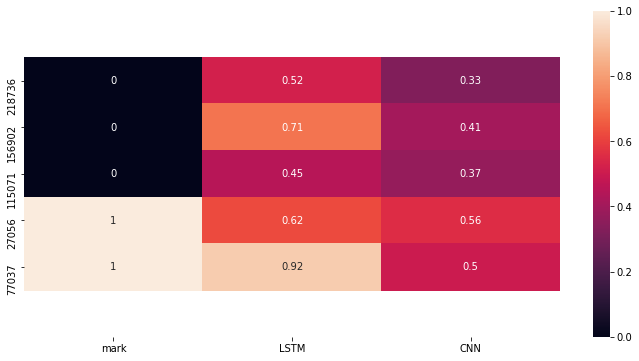

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 6))

ax = sns.heatmap(data_test, annot=True)
i, k = ax.get_ylim()
ax.set_ylim(i+1, k-1)